In [39]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter

from market_dynamics import bs_delta, bs_call_price

from data import DataFromFile
from utils import call_payoff, stochastic_integral
from models import ControlNet
from train import train_dataset, test
from evaluation import get_eval_data

import yfinance as yf
from arch import arch_model
import dask.dataframe as dd

from tqdm import tqdm, trange

from typing import Callable, Optional

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


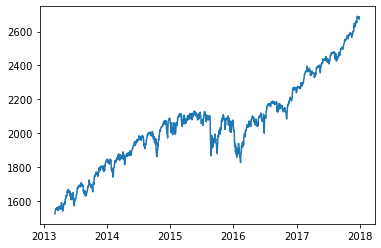

In [40]:
ticker = yf.Ticker('^GSPC')
hist = ticker.history(period='1y', start='2013-03-05', end='2018-01-02')
initial_value = hist.Close.iloc[-1]
rets = 100 * hist.Close.pct_change().dropna()
plt.plot(hist.Close)

In [41]:
fit_model = arch_model(rets, p=1, o=1, q=1, dist='t') #Right now fit to full data set, o=1 for gjr-garch
res = fit_model.fit(disp='off')
params = res.params
params

mu          4.937301e-02
omega       2.947883e-02
alpha[1]    1.055132e-11
gamma[1]    3.811128e-01
beta[1]     7.770165e-01
nu          5.719110e+00
Name: params, dtype: float64

In [42]:
h_params = {"N_SIM": 10 ** 6, #The parameters as specificied in the paper
            "RF": 0,
            "N_DIMS": 2,
            "FC_DIM": 20,
            "LR": 0.004,
            "GAMMA": 1,
            "EPOCHS": 40,
            "EPOCHS_2": 5, 
            "BATCH_SIZE": 10_000,}

In [43]:
strike = np.ceil(initial_value * 1.02)
sigma = (res._volatility[-1] / 100) * (252**0.5)
n_steps = 50
price = bs_call_price(n_steps, initial_value, sigma, h_params["RF"], strike)
initial_value, strike, sigma, price

(2673.610107421875, 2728.0, 0.06413026856822653, 7.0684978380948)

In [75]:
class DataFromFolder(Dataset):
    def __init__(
        self,
        folder_path: str,
        price: float,
        payoff: Callable,
        payoff_params: dict,
        splits: int,
        init_val: float,
        mu: float,
        take_log: bool = False
    ):

        self.folder_path = folder_path
        self.price = price
        self.payoff = payoff
        self.payoff_params = payoff_params
        self.splits = splits
        self.take_log = take_log

    def __len__(self):
        return self.splits

    def __getitem__(self, idx):
        
        # Assume that you pass number of batch as index
        x = pd.read_parquet(f"{self.folder_path}gjrpath{idx}.parquet")
        x = x.T + 0.3374 #UGLY
        x = np.exp(x/100)
        x.insert(loc=0, column='initvalue', value=2673.610107421875)
        x = np.cumprod(x,axis=1)
        x = x.values
        x = x.reshape(x.shape[0], x.shape[1], 1)
        x = torch.from_numpy(x).float()
        
        # Skipping batches that haves problematic paths (e.g., path goes to infinity or 0)
        if x.isinf().sum() + x.isnan().sum() + (x <= 0).sum() > 0:
            print(f"data problem with {idx}")
            return None, None, None, None
        
        if not self.take_log:
            return (
                x[:, :-1],
                x.squeeze().diff(),
                self.payoff(x, **self.payoff_params),
                self.price * torch.ones(x.shape[0]),
            )
        else:
            return (
                torch.log(x[:, :-1]),
                x.squeeze().diff(),
                self.payoff(x, **self.payoff_params),
                self.price * torch.ones(x.shape[0]),
            )

In [95]:
def train_dataset(
    dataset,
    model,
    criterion,
    optimizer,
    epochs,
    writer,
    scheduler=None,
    device="cpu",
    metric=None,
    p=1,  # percentage of data set to use in each epoch
    max_norm=10,
):
    last = None
    
    losses = []
    metrics = []
    
    model.train()
    
    for epoch in range(epochs):

        running_loss = 0
        running_metric = 0
        
        if p != 1:
            indices = np.random.choice(np.arange(dataset.splits)+1, size=int(np.ceil(p * dataset.splits)), replace=False)
        else:
            indices = np.arange(dataset.splits)

        with tqdm(indices, unit="batch") as tepoch:
            for i in tepoch:
                tepoch.set_description(f"Epoch {epoch}")

                x, x_inc, payoff, price = dataset[i]
                
                if x is None:  # None means that there are strange paths in the batch (e.g., x going to 0 or infty); skip those in training
                    continue
                
                x, x_inc, payoff, price = (
                    x.to(device),
                    x_inc.to(device),
                    payoff.to(device),
                    price.to(device),
                )

                
                optimizer.zero_grad()
                if not model.learn_price:
                    output = model(x)
                else:
                    output, price = model(x)
                si = stochastic_integral(x_inc, output)
                loss = criterion((price.squeeze() + si).float(), payoff.float())

                # Debugging
                if output.isnan().sum() > 0:
                    print(f"nan loss occured with file {i}")
                    print(output)
                    print(price.shape)
                    print(si)
                    
                    sys.exit()
                    
                loss.backward()
                
                # Clipping gradients
                torch.nn.utils.clip_grad_norm_(cn.parameters(), max_norm=max_norm)
                
                optimizer.step()
                
                met = metric(price + si, payoff).item()
                running_metric += met
                running_loss += loss.item()
          
                if metric is not None:
                    tepoch.set_postfix(
                        {
                            "loss": loss.item(),
                            "metric": met,
                        }
                    )
                else:
                    tepoch.set_postfix(loss=loss.item())


        if scheduler is not None:
            scheduler.step()

        writer.add_scalar(
            "Average Loss in Epoch",
            running_loss,
            epoch * dataset.splits,
        )

        writer.close()
        
        losses.append(running_loss / (256 * len(indices)))
    
    return losses, metrics

In [96]:
dt = DataFromFolder("gjrpaths/", price, call_payoff, {"strike": strike}, 2000, initial_value, 0.3374, take_log=True)

In [97]:
cn = ControlNet(n_steps, 1, [20, 20], 1, learn_price=True)
optimizer = Adam(cn.parameters(), lr=h_params["LR"])
scheduler = ExponentialLR(optimizer, gamma=1)

In [98]:
# Some loss functions

def trimmed_mean_loss(preds, targets, alpha=0.01, criterion=torch.nn.MSELoss(reduction='none'), reduction='mean'):
    loss = criterion(preds, targets)
    q = torch.quantile(loss, 1 - alpha)
    if reduction == 'mean':
        return loss[loss < q].mean()
    elif reduction == 'none':
        return loss[loss < q]

# was an idea, but really makes not a lot of sense to use in backprop
def median_loss(preds, targets, criterion=torch.nn.MSELoss(reduction='none')):
    loss = criterion(preds, targets)
    return loss.median()


def loss_robust(preds, targets, criterion=torch.nn.SmoothL1Loss(reduction='none', beta=10)):
    loss = criterion(preds, targets)
    loss = loss.nan_to_num(nan=10_000)
    return loss.mean()

In [99]:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
comment = ""
log_dir = os.path.join('experiments', current_time + '_' + comment)
writer = SummaryWriter(log_dir)

losses = train_dataset(dt, cn, loss_robust, optimizer, 20, writer, scheduler, metric=median_loss, p=0.01)

Epoch 19: 100%|██████████████████████████████████████████████| 20/20 [00:01<00:00, 11.25batch/s, loss=7.62, metric=66]


In [100]:
n_of_training_paths = 10_000 * int(np.ceil(0.01 * dt.splits)) * 20
n_of_training_paths / (10 ** 6)

4.0

In [101]:
losses

([0.9447009682655334,
  0.18360010012984276,
  0.10938203483819961,
  0.08658212535083294,
  0.10218465887010098,
  0.0883537121117115,
  0.10757773295044899,
  0.06978000160306692,
  0.06559580955654383,
  0.06132596405223012,
  0.06346379751339555,
  0.08337897974997759,
  0.05517817120999098,
  0.057628095149993896,
  0.05057274289429188,
  0.04925028588622808,
  0.048981521278619766,
  0.05958937965333462,
  0.04849355947226286,
  0.039558340795338154],
 [])

In [102]:
# Delta hedging benchmark
# Does this make sense with constant vola???
# n_steps not constant!!! I think we had this wrong the entire project!!

def delta(x):
    return bs_delta(n_steps, x, sigma, h_params["RF"], strike)

In [103]:
n = 10

diffs = []
diffs_delta = []

# make index to pass decreasing time to maturity to the bs_delta function
idx = np.arange(n_steps) + 1
idx = idx[::-1]

for i in trange(1,n+1):
    x, x_inc, payoff, price = dt[i]

    # calculate delta hedge; assuming x is log price!
    hedge_list = [torch.Tensor([bs_delta(idx[j], torch.exp(path[j]), sigma, 0, strike) for j in range(n_steps)]).unsqueeze(0) for path in x.squeeze()]
    d_hedge = torch.cat(hedge_list)
    si_delta = stochastic_integral(x_inc, d_hedge)
    diff_delta = (price.squeeze() + si_delta).float() - payoff.float()
    diffs_delta.append(diff_delta)

    # calculating model hedge
    if cn.learn_price:
        output, price = cn(x)
    else:
        output = cn(x)
        
    si = stochastic_integral(x_inc, output)
    diff = (price.squeeze() + si).float() - payoff.float()
    diffs.append(diff)


d = torch.cat(diffs)
d_delta = torch.cat(diffs_delta)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.17s/it]


In [104]:
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

RMSE 53.240962982177734
Using median 6.984375
Using mode 0.5809326171875


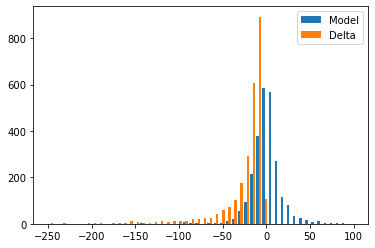

In [92]:
plt.hist([d.detach().numpy(), d_delta.detach().numpy()], range=(-250, 100), bins=50, label=['Model', 'Delta'])
plt.legend();

In [93]:
pd.Series(d_delta.detach()).describe()

count    2560.000000
mean      -25.942312
std        35.909565
min      -462.815125
25%       -26.625519
50%       -14.852119
75%        -9.332733
max        -1.485260
dtype: float64

In [94]:
d_series = pd.Series(d.detach())
d_series.describe()

count    2560.000000
mean       -4.101403
std        84.548019
min     -2406.591553
25%        -7.882828
50%         0.523438
75%         8.037037
max       451.553009
dtype: float64